In [1]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr


from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

/Users/dormann/Documents/GitHub/src


In [2]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
all_norm = np.array(pd.read_csv('../data/processed_data/all.csv')).T
y = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_all.csv')))
ind_dataset = np.squeeze(np.array(pd.read_csv('../data/processed_data/size_datasets.csv')))

all_norm.shape

(7615, 9353)

In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(all_norm,y)

In [5]:
print(all_norm.shape, len(pred))
acc = model.score_
print(acc)

(7615, 9353) 7615
0.11744186046511627


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (606, 4554, 0.13306982872200263, 0.2547288776796974, 0.9994895926895865, 0.11744186046511627, 0.999801222153023, 0.8825581395348837, 0.7452711223203027)


# Mutual information maximizer (MIM)

test 0.1914366955275592 0.010972898469513468
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (586, 4443, 0.13189286518118387, 0.25701754385964914, 0.9995073699364604, 0.11652415987273812, 0.9998121157398098, 0.8834758401272619, 0.7429824561403509)
0.8634274458305975


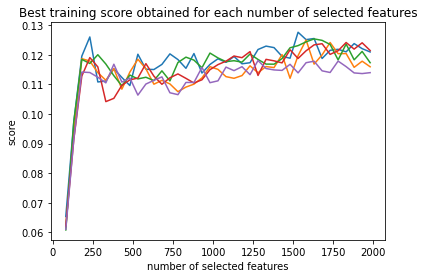

In [7]:
#Define parameters for MIM method
N = np.arange(80,2000,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,all_norm, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluates on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = all_norm[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))
print(model.recovery)

In [8]:
#Create .csv with names of this subset
get_best_genes_names(subset, '../data/processed_data/allgenes_interest.csv', '../data/optimized_subsets/allgenes_bestMIM.csv')

# Anova F test

test 0.23157561375160712 0.010960398110861531
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (727, 4268, 0.1703373945641987, 0.30649241146711637, 0.9995306024543729, 0.14554554554554555, 0.999819029573868, 0.8544544544544544, 0.6935075885328836)
0.8698621142481944


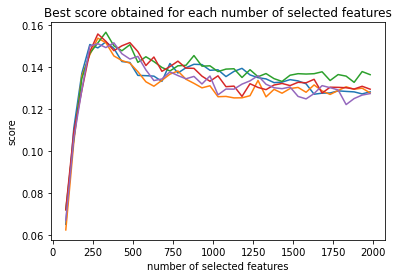

In [9]:
#Define parameters for ANOVA method
N = np.arange(80,2000,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,all_norm, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = all_norm[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    
print(model.recovery)

In [10]:
#Create .csv with names of this subset
get_best_genes_names(subset, '../data/processed_data/allgenes_interest.csv', '../data/optimized_subsets/allgenes_bestANOVA.csv')

# Every data set but switch which is used for training and which is used for testing

In [11]:
def getTrainTestAll(y:np.array, x:np.array, ind_dataset:list, i:int):
    """Split the merged data, one data set is keept for testing, the others for training.
  
      parameters:
      y : np.array,
        family of each data points
      x : np.array,
        features of each data points
      ind_dataset : list,
        list of indices where each data set is stored
      i: int, 
        ind of the data set to keep for testing
        

      returns:
      x_train : np.array,
        norm data without the test dataset for training
      y_train : np.array,
        families of each data point without the test dataset for training
      x_test : np.array,
        norm data of the test dataset
      y_test : np.array,
        families of each data point of the test dataset"""
    
    ind_i = None
    if i == 0:
        ind_i = np.arange(0,ind_dataset[i],1)
    else:
        ind_i = np.arange(ind_dataset[i-1], ind_dataset[i], 1)
    
    
    x_train = np.delete(x, ind_i, axis=0)
    y_train = np.delete(y, ind_i)
    x_test = x[ind_i,:]
    y_test = y[ind_i]
    
    return x_train, y_train, x_test, y_test

In [12]:
 def optimization_on_allsets(y:np.array, x:np.array, ind_dataset:list, Model_test: Callable, Scoring_test: Callable, maximize_test:bool, func: Callable, **kwargs: dict):
    """ 
  
      parameters:
      y : np.array,
        family of each data points
      x : np.array,
        features of each data points
      ind_dataset : list,
        list of indices where each data set is stored
      Model_test : Callable,
        the model is fitted using this method
      Scoring_test: Callable,
        scoring function use to evaluate the model
      maximize_test: bool,
        if True the scoring function is maximize, else it is minimize
      func: Callable,
        feature selection function, should return seleted subset and associated score
      kwargs: **kwargs : dict,
        dictionnary of parameters and their values (kwargs = {'param_name' : value}) to pass to the given method (func)
        

      returns:
      final_subset : np.array,
        subset of features with the best score
      best_test_score : float,
        test score obtained with the best subset of features """
    
    #Store score training and best subset
    score_training = []
    score_testing = []
    final_subset = []
    
    for i in range(0,len(ind_dataset)):
        #Get split data
        x_train, y_train, x_test, y_test = getTrainTestAll(y, x, ind_dataset, i)
        print(y.shape, y_train.shape, y_test.shape)
        print(x.shape, x_train.shape, x_test.shape)
        
        #Run feature selection on training set
        subset, score = func(y_train, x_train, **kwargs)
        
        #Evaluate subset on test set
        model_test = Model_test(np.unique(y_test),Scoring_test,True)
        pred_test = model_test.fit_predict(x_test[:, subset],y_test)
        test_score = model_test.score(x_test[:, subset],y_test)
        
        #Store best score and best subset on current folds
        score_training.append(score)
        score_testing.append(test_score)
        final_subset.append(subset)
        
    return final_subset, score_training, score_testing

# Mutual information maximizer (MIM)

In [ ]:
#Define parameters for MIM method
N = np.arange(80,1500,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset_MIM, score_training, score_testing = optimization_on_allsets(y,all_norm, ind_dataset, FamiliesClusters, compute_precision,True, MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

(7615,) (7282,) (333,)
(7615, 9353) (7282, 9353) (333, 9353)
(7615,) (6142,) (1473,)
(7615, 9353) (6142, 9353) (1473, 9353)
(7615,) (7154,) (461,)
(7615, 9353) (7154, 9353) (461, 9353)


In [ ]:
#Create .csv with names of this subset
for i, subset in enumerate(subset_MIM):
    get_best_genes_names(subset, '../data/processed_data/allgenes_interest.csv', '../data/optimized_subsets/allgenes_bestMIM' + str(i) + '.csv')

# Anova F test

In [ ]:
#Define parameters for ANOVA method
N = np.arange(80,2000,50)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset_ANOVA, score_training, score_testing = optimization_on_allsets(y,all_norm, ind_dataset, FamiliesClusters, compute_precision,True, ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

In [ ]:
#Create .csv with names of this subset
for i, subset in enumerate(subset_ANOVA):
    get_best_genes_names(subset, '../data/processed_data/allgenes_interest.csv', '../data/optimized_subsets/allgenes_bestANOVA' + str(i) + '.csv')